In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud #just in case, regularly update your lucem_illud with the following code: pip install git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import gensim#For word2vec, etc

import requests #for http requests
import pandas as pd #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls
import seaborn as sns#Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
import datetime as dt
import random

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('merged.csv')#['tokenized_text'][:30]

In [4]:
df_2020 = pd.read_csv('reddit_2020.csv')

In [5]:
df = df.append(df_2020[df_2020['time'] < '2020-12-20']).sort_values('time')

In [6]:
def na_value(x):
    if type(x) == float:
        return ''
    else:
        return x

df['title'] = df['title'].apply(na_value)

np.sum(df['title'].apply(lambda x: type(x) == float))

0

In [54]:
df.to_csv('full.csv')

In [8]:
%%time
df['tokenized_text'] = df['title'].apply(lambda x: lucem_illud.word_tokenize(x))
df['normalized_tokens'] = df['title'].apply(lambda x: lucem_illud.normalizeTokens(x))

CPU times: user 5min 27s, sys: 14.7 s, total: 5min 42s
Wall time: 6min 44s


In [9]:
df['gme'] = df['normalized_tokens'].apply(lambda x: 1 if 'gme' in x or 'gamestop' in x or '$gme' in x else 0)

In [10]:
df['time'] = df['time'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
                 #100*x.year + x.month)

In [11]:
df['ym'] = df['time'].apply(lambda x: 100*x.year + x.month)

In [12]:
df_ym = pd.DataFrame()
df_ym['ym'] = list(df.groupby('ym').count().index)
ym_lst = list(df.groupby('ym').count().index)

In [34]:
%%time
merged_tokens = []
for ym in ym_lst:
    print(ym)
    sample = random.sample(list(df[df['ym'] == ym]['reduced_tokens']), 10000)
    tokens_ym = np.array(sample).sum()
    merged_tokens.append(tokens_ym)

202010
202011
202012
202101
202102
202103
202104
202105
202106
CPU times: user 8.79 s, sys: 910 ms, total: 9.7 s
Wall time: 12 s


In [35]:
df_ym['reduced_tokens'] = merged_tokens

In [36]:
df_ym

,ym,reduced_tokens
0,202010,"[bet, gme, late, tomorrow, group, app, yesterd..."
1,202011,"[try, buy, morning, make, hit, gme, fuck, red,..."
2,202012,"[think, tsla, trade, day, tesla, moon, gme, co..."
3,202101,"[robinhood, need, focus, gme, rest, meme, late..."
4,202102,"[delete, user, tendies, gme, amc, bb, nok, ctr..."
5,202103,"[gme, gamestop, business, strategy, rkt, float..."
6,202104,"[delete, user, thought, sos, moon, stock, shor..."
7,202105,"[rich, crash, set, anybody, hold, massive, bag..."
8,202106,"[discussion, delete, user, twitter, bb, moon, ..."


In [30]:


#df[df['ym'] == 202101]#['reduced_tokens']
test = random.sample(list(df[df['ym'] == 202101]['reduced_tokens']), 3)

In [29]:
df['reduced_tokens'][:5]

59902                                         []
59630                                         []
59631                               [dd, inside]
59632    [throw, stock, say, post, fuck, boomer]
59633                                   [retard]
Name: reduced_tokens, dtype: object

In [14]:
%%time
#initialize
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
#initialize
TFVects = TFVectorizer.fit_transform(df['title'])

CPU times: user 11.8 s, sys: 845 ms, total: 12.6 s
Wall time: 13.2 s


In [15]:
%%time
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

df['reduced_tokens'] = df['normalized_tokens'].apply(lambda x: dropMissing(x, TFVectorizer.vocabulary_.keys()))

CPU times: user 4.66 s, sys: 4.74 s, total: 9.4 s
Wall time: 12.2 s


In [39]:
%%time
dictionary = gensim.corpora.Dictionary(df['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in df['reduced_tokens']]
gensim.corpora.MmCorpus.serialize('reddit.mm', corpus)
reddit = gensim.corpora.MmCorpus('reddit.mm')

CPU times: user 37.3 s, sys: 8.64 s, total: 45.9 s
Wall time: 1min 6s


In [40]:
%%time
lda = gensim.models.ldamodel.LdaModel(corpus=reddit, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

CPU times: user 2min 5s, sys: 8.79 s, total: 2min 14s
Wall time: 2min 37s


In [41]:
topicsDict = {}
for topicNum in range(lda.num_topics):
    topicWords = [w for w, p in lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,need,moon,stock,dd,wish,amc,clov,gme,ape,bb
1,option,buy,let,delete,yolo,short,hold,share,today,come
2,trade,day,clne,user,like,squeeze,time,market,week,right
3,help,tomorrow,money,play,think,sell,hodl,price,good,thought
4,invest,dip,guy,ready,look,new,fuck,way,strong,loss
5,sndl,ride,big,rocket,company,wkhs,uwmc,hand,great,month
6,coin,fund,know,run,gain,wsb,long,try,news,soon
7,position,hedge,meme,hit,post,high,year,tell,real,blackberry
8,break,thing,want,target,start,retard,clf,stop,huge,miss
9,boy,pltr,thank,tendies,love,potential,say,diamond,tlry,hear


In [42]:
%%time
ldaDF = pd.DataFrame({
        'yearmonth' : df_ym['ym'],
        'topics' : [lda[dictionary.doc2bow(l)] for l in df_ym['reduced_tokens']]
    })

CPU times: user 163 ms, sys: 328 ms, total: 492 ms
Wall time: 617 ms


In [44]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(lda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

#ldaDF[1::100]

In [45]:
ldaDF

,yearmonth,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,202010,"[(0, 0.106347926), (1, 0.090746365), (2, 0.143...",0.106348,0.090746,0.143999,0.102217,0.106905,0.100217,0.086860,0.094671,0.087769,0.080269
1,202011,"[(0, 0.0878869), (1, 0.1545847), (2, 0.1319073...",0.087887,0.154585,0.131907,0.102128,0.105613,0.093888,0.086890,0.086114,0.084928,0.066061
2,202012,"[(0, 0.098094456), (1, 0.121385224), (2, 0.140...",0.098094,0.121385,0.140940,0.084858,0.105879,0.100645,0.090078,0.099799,0.084833,0.073490
3,202101,"[(0, 0.09127088), (1, 0.10875408), (2, 0.15277...",0.091271,0.108754,0.152772,0.062620,0.075500,0.127293,0.097529,0.141092,0.079917,0.063251
4,202102,"[(0, 0.07591421), (1, 0.117134005), (2, 0.1341...",0.075914,0.117134,0.134197,0.059865,0.075269,0.128743,0.108110,0.149266,0.090464,0.061037
5,202103,"[(0, 0.07982429), (1, 0.10848985), (2, 0.12224...",0.079824,0.108490,0.122249,0.068405,0.093908,0.122904,0.086803,0.145073,0.111057,0.061286
6,202104,"[(0, 0.08741175), (1, 0.1001923), (2, 0.133015...",0.087412,0.100192,0.133015,0.066066,0.105155,0.135399,0.091616,0.111917,0.105086,0.064143
7,202105,"[(0, 0.09139513), (1, 0.105339706), (2, 0.1316...",0.091395,0.105340,0.131666,0.067801,0.095546,0.144862,0.089237,0.107092,0.103106,0.063955
8,202106,"[(0, 0.07291515), (1, 0.099186), (2, 0.1307121...",0.072915,0.099186,0.130712,0.062801,0.106881,0.158768,0.094663,0.086935,0.106589,0.080550


In [47]:
ldaDFV = ldaDF[['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[['yearmonth']]
#ldaDFVis = ldaDFV.as_matrix(columns=None)
#ldaDFVisNames = ldaDFVisN.as_matrix(columns=None) 
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.106348,0.090746,0.143999,0.102217,0.106905,0.100217,0.086860,0.094671,0.087769,0.080269
1,0.087887,0.154585,0.131907,0.102128,0.105613,0.093888,0.086890,0.086114,0.084928,0.066061
2,0.098094,0.121385,0.140940,0.084858,0.105879,0.100645,0.090078,0.099799,0.084833,0.073490
3,0.091271,0.108754,0.152772,0.062620,0.075500,0.127293,0.097529,0.141092,0.079917,0.063251
4,0.075914,0.117134,0.134197,0.059865,0.075269,0.128743,0.108110,0.149266,0.090464,0.061037
5,0.079824,0.108490,0.122249,0.068405,0.093908,0.122904,0.086803,0.145073,0.111057,0.061286
6,0.087412,0.100192,0.133015,0.066066,0.105155,0.135399,0.091616,0.111917,0.105086,0.064143
7,0.091395,0.105340,0.131666,0.067801,0.095546,0.144862,0.089237,0.107092,0.103106,0.063955
8,0.072915,0.099186,0.130712,0.062801,0.106881,0.158768,0.094663,0.086935,0.106589,0.080550


In [48]:
ldaDFVis = np.array(ldaDFV)
ldaDFVisNames = np.array(ldaDFVisN)

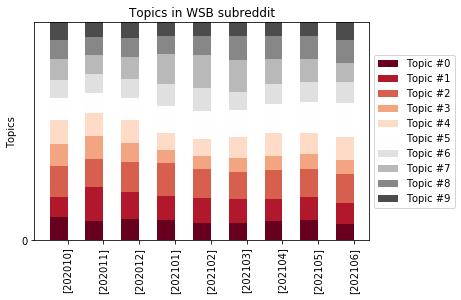

In [53]:
N = 9
ind = np.arange(N)
K = lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.RdGy(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in WSB subreddit')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()